In [1]:
import pandas as pd 
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, RFECV
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

pd.set_option('display.max_columns', None)

# 1 Data process

In [2]:
conso = pd.read_csv('eco2mix-metropoles-tr.csv', sep=';') #données consommation métropole
meteo = pd.read_csv('meteo-france-donneesq-covid19.csv', sep =';', encoding = 'latin1', on_bad_lines='skip', decimal=',')
dpe = pd.read_excel('DPE.xlsx')
logement = pd.read_excel('Logement_final.xlsx')

C:\Users\alexi\AppData\Local\Temp\ipykernel_8372\528103535.py:1: DtypeWarning: Columns (7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  conso = pd.read_csv('eco2mix-metropoles-tr.csv', sep=';') #données consommation métropole


## 1.1 Météo : meteo

In [3]:
meteo['Date'] = pd.to_datetime(meteo['DATE'], format='%Y%m%d').dt.strftime('%Y-%m-%d')
meteo.drop(columns=['DATE', 'POSTE', 'POSTE', 'LON', 'LAT', 'ALT', 'QRR', 'QTN', 'QTX', 'QTM', 'QFFM', 'QUN', 'QUX', 
                         'QDHUMI40', 'QDHUMI80', 'QUM'], inplace=True)                      

In [4]:
meteo = meteo.rename(columns={'RR' : 'Precipitation', 
                                      'TN' : 'Temperature_minimale',
                                      'TX' : 'Temperature_maximale', 
                                      'TM' : 'Temperature_moyenne',
                                      'FFM' : 'Moyenne_du_vent_a_10m', 
                                      'UN' : 'Humidite_relative_minimale',
                                      'UX' : 'Humidite_relative_maximale',
                                      'DHUMI40' : 'Duree_humidite_inf_a_40_pct', 
                                      'DHUMI80' : 'Duree_humidite_sup_a_80_pct',
                                      'UM' : 'Humidite_moyenne',
                                      'NOM' : 'Ville'})

## 1.2 Consommation par métropole : conso

In [5]:
#Harmonisation des noms de ville avec le nom des stations météo
conso['Ville']=''
conso.loc[conso['Métropole'] == 'Clermont Auvergne Métropole', 'Ville'] = 'CLERMONT-FD'
conso.loc[conso['Métropole'] == "Métropole d'Aix-Marseille-Provence", 'Ville'] = 'MARSEILLE'
conso.loc[conso['Métropole'] == 'Métropole de Lyon', 'Ville'] = 'LYON-BRON'
conso.loc[conso['Métropole'] == 'Dijon Métropole', 'Ville'] = 'DIJON-LONGVIC'
conso.loc[conso['Métropole'] == 'Métropole Grenoble-Alpes-Métropole', 'Ville'] = 'GRENOBLE-ST GEOIRS'
conso.loc[conso['Métropole'] == 'Métropole Européenne de Lille', 'Ville'] = 'LILLE-LESQUIN'
conso.loc[conso['Métropole'] == 'Métropole du Grand Nancy', 'Ville'] = 'NANCY-ESSEY'
conso.loc[conso['Métropole'] == 'Montpellier Méditerranée Métropole', 'Ville'] = 'MONTPELLIER-AEROPORT'
conso.loc[conso['Métropole'] == 'Nantes Métropole', 'Ville'] = 'NANTES-BOUGUENAIS' 
conso.loc[conso['Métropole'] == 'Bordeaux Métropole', 'Ville'] = 'BORDEAUX-MERIGNAC' 
conso.loc[conso['Métropole'] == 'Brest Métropole', 'Ville'] = 'BREST-GUIPAVAS' 
conso.loc[conso['Métropole'] == "Métropole Nice Côte d'Azur", 'Ville'] = 'NICE'
conso.loc[conso['Métropole'] == "Métropole du Grand Paris", 'Ville'] = 'PARIS-MONTSOURIS'
conso.loc[conso['Métropole'] == "Eurométropole de Strasbourg", 'Ville'] = 'STRASBOURG-ENTZHEIM'
conso.loc[conso['Métropole'] == "Saint-Etienne Métropole", 'Ville'] = 'ST ETIENNE-BOUTHEON' 
conso.loc[conso['Métropole'] == "Métropole Rennes Métropole", 'Ville'] = 'RENNES-ST JACQUES'
conso.loc[conso['Métropole'] == "Métropole Rouen Normandie", 'Ville'] = 'ROUEN-BOOS'
conso.loc[conso['Métropole'] == "Métropole Toulon-Provence-Méditerranée", 'Ville'] = 'HYERES'
conso.loc[conso['Métropole'] == "Toulouse Métropole", 'Ville'] = 'TOULOUSE-BLAGNAC'
conso.loc[conso['Métropole'] == "Orléans Métropole", 'Ville'] = 'ORLEANS'
conso.loc[conso['Métropole'] == "Tours Métropole Val de Loire", 'Ville'] = 'TOURS'

#nom métropole = station météo

In [6]:
conso.dropna(subset='Consommation (MW)', inplace=True)

In [7]:
conso['Date'] = pd.to_datetime(conso['Date'])
meteo['Date'] = pd.to_datetime(meteo['Date'])
conso_mean = conso.groupby(["Ville", pd.Grouper(key="Date", freq="D")]).agg({"Consommation (MW)": "sum"}).reset_index()

#électricité totale par jour par ville

In [8]:
#conso_mean['Date'] = conso_mean['Date'].dt.strftime('%Y-%m-%d') 
df = pd.merge(conso_mean, meteo, on=['Date', 'Ville'], how='left')

## 1.3 DPE

In [9]:
df_aggregated = df.groupby(['Ville'])['Consommation (MW)'].sum().reset_index() 
df_dpe = pd.merge(df_aggregated, dpe, on='Ville', how='left')

In [10]:
df_aggregated = df.groupby(['Ville'])['Consommation (MW)'].sum().reset_index() 


In [11]:
df_dpe = pd.merge(df_aggregated, dpe, on='Ville', how='left')

In [12]:
df_dpe['D-E'] = df_dpe['D'] + df_dpe['E']
df_dpe.rename(columns={"%F&G ensemble" : "F-G"}, inplace=True)
df_dpe.drop(columns=['D', 'E', 'F', 'G'], inplace=True)
df_dpe = df_dpe.reindex(columns=['Ville', 'Consommation (MW)', 'A-B-C', 'D-E', 'F-G', 'Nombre de DPE F ou G', 'Nombre de DPE'])

## 1.4 Dataset de control 

In [13]:
#création d'un dataset de control avec dpe + logement
control = pd.merge(df_dpe, logement, on='Ville', how='left')

### 1.4.1 Consommation par logement : création de la target

On divise la consommation par ville par son nombre de logements occupés

In [14]:
df = pd.merge(df, control[['Ville', 'Nb_logement', 'F-G', 'Construit_av_1919',
                               'Construit_1919-1945']], on='Ville', how='left')


In [15]:
# 1 kWh = 0.001 MWh
df['consokwh'] = df['Consommation (MW)']*1000 #conso en kwh
df['conso_par_log'] = df['consokwh']/df['Nb_logement'] #conso par hab en kwh

In [16]:
df['conso_par_log'].mean() #consommation moyenne par jour 290.6 kwh (moy/hab = 45, donc cohérent si ajout des transports etc)

290.90782224807464

### 1.4.2 Pourcentage de logement mal isolés

In [17]:
df['F-G'] = df['F-G']*100 #multiplication de la part entre 0 et 1 par 100

### 1.4.3 Pourcentage de logements construits avant 1945

In [18]:
df['part_log_ancien'] = ((df['Construit_av_1919']+ df['Construit_1919-1945'])/df['Nb_logement'])*100

## 1.5 Stats desc

In [19]:
df_desc = df.groupby('Ville').agg({'Consommation (MW)': 'mean', 'Temperature_moyenne': 'mean', 
'Moyenne_du_vent_a_10m': 'mean', 'Humidite_moyenne': 'mean', 
'Precipitation': 'mean','F-G':'mean', 'part_log_ancien':'mean'}).reset_index()

In [20]:
df_desc.set_index('Ville', inplace=True)

for col in df_desc.columns:
    min_val = df_desc[col].idxmin()
    max_val = df_desc[col].idxmax()
    mean_val = df_desc[col].mean()
    nearest_val = df_desc[col].sub(mean_val).abs().idxmin()
    print(f"{col}: ville min = {min_val} ({df_desc.loc[min_val, col]}), ville max = {max_val} ({df_desc.loc[max_val, col]}) ville moy = ({mean_val}) ({nearest_val}), vraie valeur = {df_desc.loc[nearest_val, col]}")


Consommation (MW): ville min = BREST-GUIPAVAS (10926.469601677149), ville max = PARIS-MONTSOURIS (403379.3689727463) ville moy = (58918.625204011965) (BORDEAUX-MERIGNAC), vraie valeur = 53109.270440251574
Temperature_moyenne: ville min = ROUEN-BOOS (10.483228511530399), ville max = NICE (15.416771488469601) ville moy = (12.367663343255341) (PARIS-MONTSOURIS), vraie valeur = 12.424528301886792
Moyenne_du_vent_a_10m: ville min = MARSEILLE (2.130252100840336), ville max = BREST-GUIPAVAS (5.193291404612159) ville moy = (3.6866981656817175) (HYERES), vraie valeur = 3.678616352201258
Humidite_moyenne: ville min = CLERMONT-FD (66.40461215932915), ville max = BREST-GUIPAVAS (83.1006289308176) ville moy = (72.81341920464317) (STRASBOURG-ENTZHEIM), vraie valeur = 73.37945492662473
Precipitation: ville min = MONTPELLIER-AEROPORT (0.9190775681341719), ville max = BREST-GUIPAVAS (3.570230607966457) ville moy = (1.7848619594527917) (PARIS-MONTSOURIS), vraie valeur = 1.7867924528301886
F-G: ville min

In [21]:
df.drop(columns = ['Consommation (MW)', 'consokwh', 'Nb_logement', 'Construit_av_1919', 'Construit_1919-1945'], inplace=True)

## 1.6 Indicateur température ressentie

### 1.6.1 Windchill

In [22]:
#windchill 

def wind_chill(df):
    T = df['Temperature_moyenne']
    V = df['Moyenne_du_vent_a_10m']
    WC = 13.12 + 0.6215 * T - 11.37 * (V ** 0.16) + 0.3965 * T * (V ** 0.16)
    return WC

In [23]:
df['Windchill'] = wind_chill(df)

### 1.6.2 Humidex

In [24]:
# Humidex

def dew_point(T, HR):
    alpha = ((17.27 * T) / (237.7 + T)) + np.log(HR / 100)
    Td = (237.7 * alpha) / (17.27 - alpha)
    return Td

def humidex(df):
    T = df['Temperature_moyenne']
    HR = df['Humidite_moyenne']
    Td = dew_point(T, HR)

    e = 6.11 * 10 ** (7.5 * T / (237.7 + T))
    es = 6.11 * 10 ** (7.5 * Td / (237.7 + Td))

    H = T + 5 / 9 * (e - 10)
    return H

In [25]:
df['Humidex'] = humidex(df)

## 1.7 Sélection de variable

In [26]:
df.isnull().sum(axis = 0)/len(df)*100 #valeurs manquantes
df.dropna(inplace=True)

In [27]:
cols = ['Precipitation',
       'Temperature_minimale', 'Temperature_maximale', 'Temperature_moyenne',
       'Moyenne_du_vent_a_10m', 'Humidite_relative_minimale',
       'Humidite_relative_maximale', 'Duree_humidite_inf_a_40_pct',
       'Duree_humidite_sup_a_80_pct', 'Humidite_moyenne', 'Windchill', 'Humidex',]# 'temperature_ressentie']

### 1.7.1 F-TEST

In [28]:
X_fscore = df[cols].astype(float).values
y_fscore = df["conso_par_log"].astype(float).values

selector = SelectKBest(f_regression, k=2)
selector.fit(X_fscore, y_fscore)

# F-test scores of all the variables
scores = selector.scores_

# Sort the variables by their F-test scores
sorted_indices = np.argsort(scores)[::-1]
sorted_cols = [cols[i] for i in sorted_indices]
print("Le F-score des variables est :")

for col in sorted_cols:
    print(f"{col}: {scores[cols.index(col)]}")

Le F-score des variables est :
Windchill: 1187.5380582523153
Temperature_moyenne: 1166.616180633499
Temperature_maximale: 1165.1600538617545
Humidex: 1078.6788011681897
Temperature_minimale: 896.5033177821659
Duree_humidite_sup_a_80_pct: 473.669432516743
Humidite_relative_minimale: 471.778103416105
Humidite_moyenne: 398.90439207707914
Duree_humidite_inf_a_40_pct: 134.5945496472297
Humidite_relative_maximale: 127.00525319663512
Moyenne_du_vent_a_10m: 28.73746241501489
Precipitation: 4.38025907064466


### 1.7.2 RFE

In [29]:
X_rfe = df[cols].astype(float).values
y_rfe = df["conso_par_log"].astype(float).values

# Initialize the model
model = LinearRegression()

# Initialize the RFECV object with the model and cross-validation parameters
selector = RFECV(estimator=model, step=1, cv=5, scoring='r2')

# Fit the RFECV object to the data
selector.fit(X_rfe, y_rfe)

# RFE ranking of the variables
ranks = selector.ranking_

# Sort the variables by their RFE ranking
sorted_indices = np.argsort(ranks)
sorted_cols = [cols[i] for i in sorted_indices]
print("Le classement RFE des variables est :")
for col in sorted_cols:
    print(f"{col}: {ranks[cols.index(col)]}")

#lowest RFE ranking is the most important variable

Le classement RFE des variables est :
Temperature_moyenne: 1
Windchill: 1
Humidex: 1
Moyenne_du_vent_a_10m: 2
Temperature_minimale: 3
Humidite_relative_minimale: 4
Humidite_moyenne: 5
Precipitation: 6
Duree_humidite_sup_a_80_pct: 7
Temperature_maximale: 8
Humidite_relative_maximale: 9
Duree_humidite_inf_a_40_pct: 10


# 2. Dataviz de Paris

In [30]:
graph = df.copy() #df pour les graph

In [31]:
#Moyenne glissante
graph['Temperature_smooth'] = graph['Temperature_moyenne'].rolling(window=7).mean()
graph['consommation_smooth'] = graph['conso_par_log'].rolling(window=7).mean()
graph['vitesse_vent_smooth'] = graph['Moyenne_du_vent_a_10m'].rolling(window=7).mean()
graph['humidite_smooth'] = graph['Humidite_relative_maximale'].rolling(window=7).mean()

In [32]:
paris = graph[graph['Ville'] == 'PARIS-MONTSOURIS']

(180.0, 454.89676016923187)

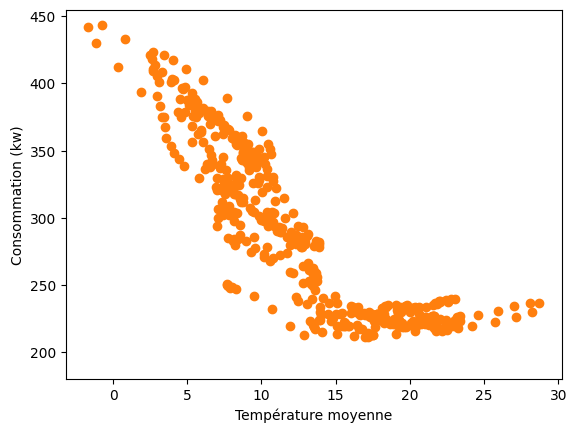

In [33]:
#température et consommation
fig, ax = plt.subplots()

ax.set_xlabel('Température moyenne')
ax.set_ylabel('Consommation (kw)')
ax.plot(paris['Temperature_smooth'], paris['consommation_smooth'],linestyle="",marker="o", color='tab:orange')
ax.tick_params(axis='y')
ax.set_ylim(bottom=180)
#ax.set_xlim(left=0, right=40)

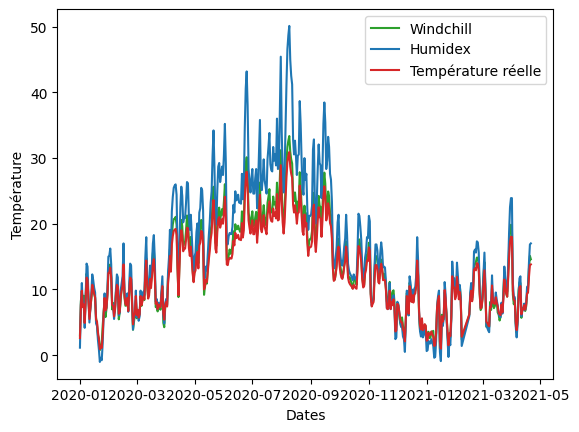

In [34]:
paris_filt = paris[paris['Windchill'] >= 0]

fig, ax = plt.subplots()

ax.plot(paris_filt['Date'], paris_filt['Windchill'], color='tab:green', label='Windchill')
ax.plot(paris_filt['Date'], paris_filt['Humidex'], color='tab:blue', label='Humidex')
ax.plot(paris_filt['Date'], paris_filt['Temperature_moyenne'], color='tab:red', label='Température réelle')

ax.legend()

ax.set_ylabel('Température')
ax.set_xlabel('Dates')

plt.show()


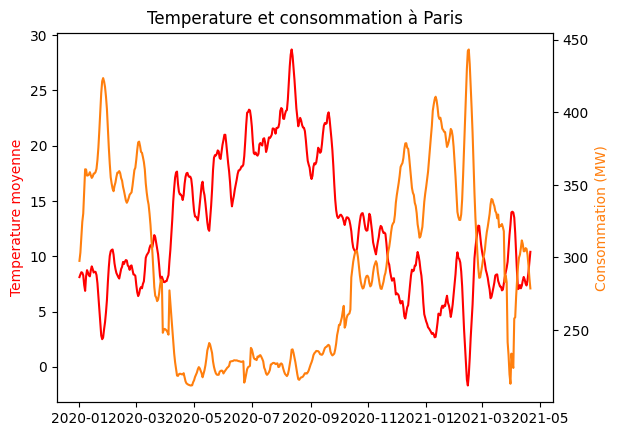

In [35]:
#Température et consommation
fig, ax = plt.subplots()
ax2=ax.twinx()
ax.plot(paris['Date'], paris['Temperature_smooth'], "-r")
ax2.plot(paris['Date'], paris['consommation_smooth'],color='tab:orange')
ax.set_ylabel('Temperature moyenne', color='r')
ax2.set_ylabel('Consommation (MW)', color='tab:orange')
ax.set_title("Temperature et consommation à Paris")
plt.show()

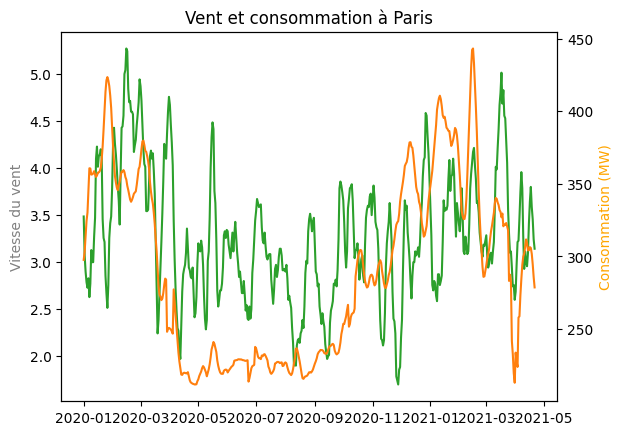

In [36]:
#Vent et consommation
fig, ax = plt.subplots()
ax2=ax.twinx()
ax.plot(paris['Date'], paris['vitesse_vent_smooth'], color='tab:green')
ax2.plot(paris['Date'], paris['consommation_smooth'],color='tab:orange')
ax.set_ylabel('Vitesse du vent', color='grey')
ax2.set_ylabel('Consommation (MW)', color='orange')
ax.set_title("Vent et consommation à Paris")
plt.show()

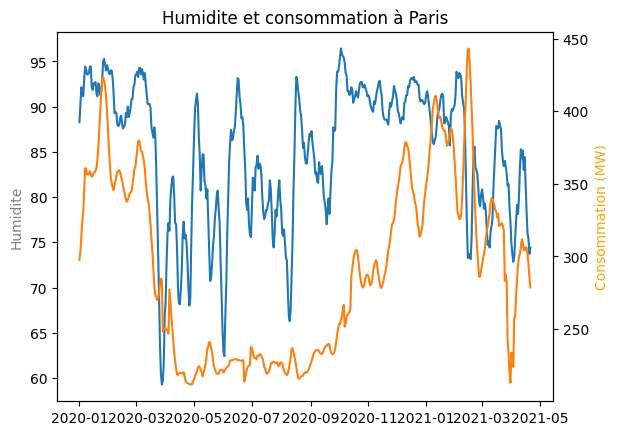

In [37]:
#humidité et consommation
fig, ax = plt.subplots()
ax2=ax.twinx()
ax.plot(paris['Date'], paris['humidite_smooth'], color='tab:blue')
ax2.plot(paris['Date'], paris['consommation_smooth'],color='tab:orange')
ax.set_ylabel('Humidite', color='grey')
ax2.set_ylabel('Consommation (MW)', color='orange')
ax.set_title("Humidite et consommation à Paris")
plt.show()

# 3. Régressions 

## 3.1 Régressions avec température ressentie et passoires thermiques

In [38]:
df = pd.merge(df, control[['Ville', 'D-E']], on='Ville', how='left')

In [39]:
df.sample(5)

,Ville,Date,Precipitation,Temperature_minimale,Temperature_maximale,Temperature_moyenne,Moyenne_du_vent_a_10m,Humidite_relative_minimale,Humidite_relative_maximale,Duree_humidite_inf_a_40_pct,Duree_humidite_sup_a_80_pct,Humidite_moyenne,F-G,conso_par_log,part_log_ancien,Windchill,Humidex,D-E
4886,NANCY-ESSEY,2020-09-21,0.0,7.6,26.8,16.7,1.2,26.0,89.0,400.0,249.0,59.0,18.6,221.695877,26.101327,18.610041,21.690829,0.671
2274,HYERES,2020-01-31,0.2,6.0,17.3,10.5,1.6,62.0,96.0,0.0,1020.0,86.0,10.4,657.085437,11.110474,11.876150,11.992238,0.563
3889,MARSEILLE,2020-08-05,0.0,16.1,31.9,24.1,1.5,19.0,63.0,620.0,0.0,41.0,7.6,224.921289,22.051698,26.162193,35.185514,0.524
4199,MONTPELLIER-AEROPORT,2020-02-24,0.0,8.1,22.0,15.6,3.9,36.0,79.0,115.0,0.0,55.0,7.7,185.390739,10.201968,16.369470,19.877117,0.461
1737,DIJON-LONGVIC,2021-03-22,0.0,1.7,7.9,4.9,5.3,49.0,82.0,0.0,137.0,66.0,16.1,246.730126,17.619788,3.855166,4.155636,0.532


In [40]:
selected_cols = ['Humidex', 'Windchill', 'Temperature_maximale', 
    'Moyenne_du_vent_a_10m', 'Humidite_relative_maximale', 'F-G']
X = df[selected_cols].astype(float).values 
y = df["conso_par_log"].astype(float).values

X = sm.add_constant(X)

model = sm.OLS(y, X)

results = model.fit()

coef_table = pd.DataFrame({
    "Variable": ["Intercept"] + selected_cols,
    "Coefficient": results.params,
    "Ecart-type": results.bse,
    "P-value": results.pvalues.round(3)
}).set_index("Variable")

print(coef_table)

                            Coefficient  Ecart-type  P-value
Variable                                                    
Intercept                    357.788021   19.889653    0.000
Humidex                       23.342021    1.619644    0.000
Windchill                    -37.555647    2.428216    0.000
Temperature_maximale          -2.574608    0.813255    0.002
Moyenne_du_vent_a_10m         -9.458888    1.084023    0.000
Humidite_relative_maximale     1.064663    0.175179    0.000
F-G                            2.645208    0.216913    0.000


## 3.2 Régressions avec température ressentie et anciens logements

In [41]:
selected_cols = ['Humidex', 'Windchill', 'Temperature_maximale', 
    'Moyenne_du_vent_a_10m', 'Humidite_relative_maximale','part_log_ancien']
X = df[selected_cols].astype(float).values 
y = df["conso_par_log"].astype(float).values

X = sm.add_constant(X)

model = sm.OLS(y, X)

results = model.fit()

coef_table = pd.DataFrame({
    "Variable": ["Intercept"] + selected_cols,
    "Coefficient": results.params,
    "Ecart-type": results.bse,
    "P-value": results.pvalues.round(3)
}).set_index("Variable")

print(coef_table)

                            Coefficient  Ecart-type  P-value
Variable                                                    
Intercept                    208.318199   19.472143    0.000
Humidex                       23.185134    1.547799    0.000
Windchill                    -38.837143    2.319828    0.000
Temperature_maximale          -0.859501    0.780103    0.271
Moyenne_du_vent_a_10m         -5.082121    1.047145    0.000
Humidite_relative_maximale     1.687920    0.168852    0.000
part_log_ancien                5.916279    0.180660    0.000
